## 과제: 피마 인디언 당뇨병 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1.EDA와 전처리

In [2]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
means = dict()
hyperparams = {
    'Glucose_Step' : 20,
    'BloodPressure_Step' : 10,
    'SkinThickness_Step' : 10,
    'Insulin_Step' : 25,
    'BMI_Step' : 4,
}

for feature in diabetes_data.columns:
    zeros_cnt = diabetes_data.loc[diabetes_data[feature] == 0, feature].count()
    means[feature] = diabetes_data.loc[diabetes_data[feature] != 0, feature].mean()
    print(f'{feature}의 0의 개수: {zeros_cnt} 0의 비율: {zeros_cnt / diabetes_data[feature].count() * 100:.2f}%')

Pregnancies의 0의 개수: 111 0의 비율: 14.45%
Glucose의 0의 개수: 5 0의 비율: 0.65%
BloodPressure의 0의 개수: 35 0의 비율: 4.56%
SkinThickness의 0의 개수: 227 0의 비율: 29.56%
Insulin의 0의 개수: 374 0의 비율: 48.70%
BMI의 0의 개수: 11 0의 비율: 1.43%
DiabetesPedigreeFunction의 0의 개수: 0 0의 비율: 0.00%
Age의 0의 개수: 0 0의 비율: 0.00%
Outcome의 0의 개수: 500 0의 비율: 65.10%


In [4]:
# 0이 존재해서는 안되는 feature들의 0값을 평균값으로 Replace.
target_feature = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for feature in target_feature:
    diabetes_data[feature] = diabetes_data[feature].replace(0, means[feature])

In [5]:
# 데이터를 특정 구간으로 분류하여 단순화하는 함수
def customScaler(target : str, step : int):
    max_val = diabetes_data[target].max()
    
    for i in range(0, math.ceil(max_val), step):
        diabetes_data.loc[(diabetes_data[target] >= i) & (diabetes_data[target] < i + step), target] = i // step

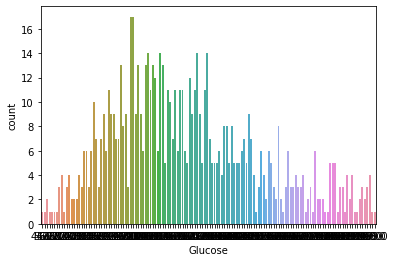

In [6]:
import seaborn as sns

sns.countplot(data=diabetes_data, x='Glucose')

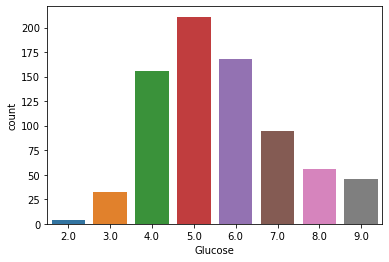

In [7]:
customScaler('Glucose', hyperparams['Glucose_Step'])
sns.countplot(data=diabetes_data, x='Glucose')

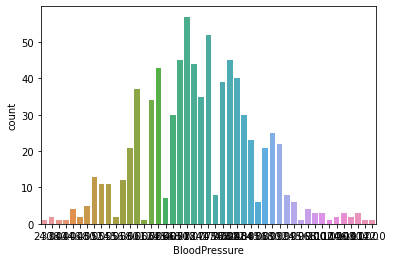

In [8]:
sns.countplot(data=diabetes_data, x="BloodPressure")

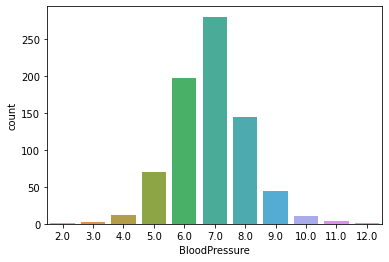

In [9]:
customScaler('BloodPressure',  hyperparams['BloodPressure_Step'])
sns.countplot(data=diabetes_data, x='BloodPressure')

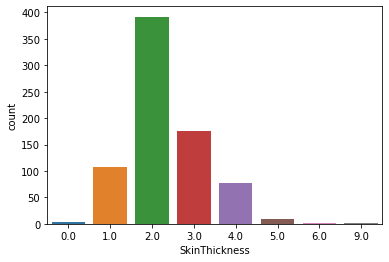

In [10]:
customScaler('SkinThickness',  hyperparams['SkinThickness_Step'])
sns.countplot(data=diabetes_data, x='SkinThickness')

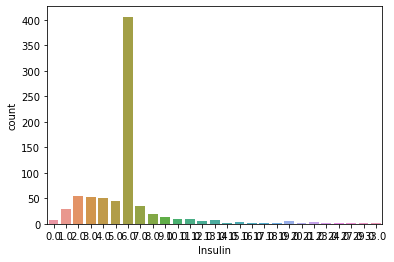

In [11]:
customScaler('Insulin',  hyperparams['Insulin_Step'])
sns.countplot(data=diabetes_data, x='Insulin')

32.45746367239099


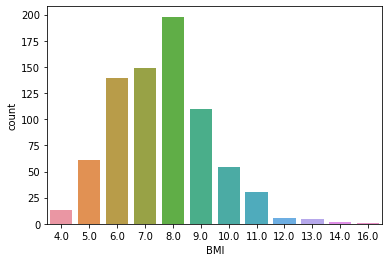

In [12]:
customScaler('BMI',  hyperparams['BMI_Step'])
print(means['BMI'])
sns.countplot(data=diabetes_data, x='BMI')

## 2.Train

In [13]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출. 
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출 
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습,예측 및 평가 수행. 
lr_clf = LogisticRegression(max_iter = 400)
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

## 3.평가

In [14]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test , pred):
    
    # 교차행렬
    confusion = confusion_matrix(y_test, pred)
    
    # 정확도 tp + tn / tot
    accuracy = accuracy_score(y_test , pred)
    
    # 정밀도 tp / tp + fp
    precision = precision_score(y_test , pred)
    
    # 재현도 tp / tp + fn
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred) #F1스코어
    roc_score = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f} AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_score))

In [15]:
get_clf_eval(y_test, pred)

오차 행렬
[[89 11]
 [18 36]]
정확도: 0.8117, 정밀도: 0.7660, 재현율: 0.6667, F1:0.7129 AUC:0.7783
